### Coupling a 3jj Flux qubit and a Josephson junction througth a capacitor.

In [3]:
#Import libraries
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
np.set_printoptions( linewidth=1000 )
import timeit
import CircuitClass_SWTPauliBasis as CClass #Import the circuit class defined in CircuitQED to create circuits.


In [4]:
# This is to make all fonts latex in matplot lib
from matplotlib import rc
rc('text', usetex=True)
# Define the font size for each part of the plot:
SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)             # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
## Define a function to extract the data from the txt.
def txt_to_npz_3JJ(EJ, EC, alpha, st, nmax, folder, neig = 7):
    lines = []                             # Declare an empty list to store lines.
    with open ('./'+folder+'/r'+str(EJ/EC)+'EJ'+str(EJ)+'alpha'+str(alpha)+'st'+str(st)+'nmax'+str(nmax)+'.dat', 'rt') as txt: # Open .txt for reading text data.
        for line in txt:                # For each line, stored as line.
            lines.append(line)

    #Extract the data from lines.
    gamma=lines[1].split() #remember that the first line are the coments so gamma=second line.
    for i in range(len(gamma)):
        gamma[i]=complex(gamma[i])
    E=np.zeros((len(gamma),neig),dtype=complex) #Matrix to store the energies values.
    for j in range(neig):
        E_aux= lines[j+2].split() #rows from 2 to 8 give the energies.
        for i in range(len(E_aux)):
            E_aux[i]=complex(E_aux[i])
        E[:,j]=E_aux

    P = np.zeros((4,4,len(gamma)),dtype=complex) #Matrix to store the P_ij values.

    # The following array defines the indices of the matrix to which values are assigned.
    # You can adjust this according to your requirements.
    indices = [(0,0), (1,1), (2,2), (3,3),
               (0,1), (1,0), (0,2), (2,0),
               (0,3), (3,0), (1,2), (2,1),
               (1,3), (3,1), (2,3), (3,2)]

    # Iterate over the indices
    for j, (x, y) in enumerate(indices):
        P_aux = lines[neig+2+j].split()
        for i in range(len(P_aux)):
            P_aux[i] = complex(P_aux[i])
        P[x,y] = P_aux

    return gamma, E, P

In [6]:
# To extract coupling, we trace out the qubit degrees of freedom to obtain a bosonic hamiltonian Hb. 
# This is done by multiplying the efefctive low-energy Hamiltonian in Heff by sigma_y and tracing over qubit. 
# If print true, it will print the full bosonic 
# Hamiltonian so one can check that it has the form of a bosonic oscillator. 
# Inputs: Heff effective Hamiltonian. nco is cutoff in the number of bosonic states. rd the accuracy to obtain results
# Outputs: the coupling.The coupling constant is obtained as the element Hb[0,1].
def coupling_constant(Heff, nco, rd, pinta = False):
    #Qubit basis = Pauli Basis (needed term)
#     σy = np.array([[0, -1j], [1j, 0]])
    σx = np.array([[0, 1], [1, 0]])#
#     σz = np.array([[1, 0], [0, -1]])
    ide = np.identity(nco)
    Hr = (np.kron(σx,ide) @ Heff).reshape((2, nco, 2, nco))
    Hb = np.trace(Hr,axis1=0, axis2=2)/2
    #Junction basis (needed term).
    P = Hb[0,1]
    if pinta:
        np.set_printoptions(suppress=True)
        print("Hb/Hb[1,0]=",np.abs(P),"*")
        print(np.round(Hb/P,3))
    return np.abs(P)

# Old code

In [5]:
#We create a subroutine to implement this circuit.
def Circuit(γ, alpha, beta, s, S, nmax, flux1, EC, EJ, pert1=0, pert2=0):
    ### s gives Cs/C and S gives EJs/EJ.  
    # This ensures alpha has at least two elements
    C=CClass.Circuit(5, nmax=nmax)
    # Add capacitances and junctions for qubit. 
    C.add_capacitance(1.0, 0, 1)
    C.add_capacitance(1.0, 0, 2)
    C.add_capacitance(alpha+beta, 1, 2) 
    C.add_junction(1, 1, +1, 0, -1)
    C.add_junction(1, 2, -1, 0, +1)
    C.add_junction(alpha*(1+pert1), 2, -1, 1, +1,-flux1)
    # Add capacitances and junctions for junction.
    C.add_capacitance(s, 3, 4)
    C.add_junction(S, 4, -1, 3, 1)
    #Coupling.
    if γ:
        C.add_capacitance(γ, 2, 3)
    #Ground.
    return C.set_ground([1,4])

In [6]:
# Subroutine to solve and project a circuit with a Josephson junction and a resonator coupled via a capacitor. The
# energies labeled with r correspond to resonator and the ones with q to qubits. The nco is the cutoff in the
# bosonic modes. alpha is ratio of junctions in the qubit and gamma strength of the coupling in units of C. For
# full Schreiffel wolf set method = "SW" and for only projection onto the low energy set "QB".
def qubit_res_old(alpha, EJq, ECq, EJr, ECr, γ, beta = 0, nco =10, pinta = False, method = "SW", fs = False):
    ## Result for Φ1=Φ2=0.5Φ0.
    #Set parameters.
    flux1=0.5*2*np.pi
    EJ= EJq
    EC= ECq
    # s is ratio between Cjunction and Cqubit. The S is ratio between EJjunction and Ejqubit
    s= EC/ECr
    S= EJr/EJq
    if type(γ) is not list:
        γ =[γ]
#     γ=np.arange(0,0.01,0.01)
    nmax=12
    rd=10
    e=1e-4

    #Matrix to store the values of the constants.  
    E=np.zeros((len(γ),2*nco))
    Eq=np.zeros((len(γ),2*nco))
    P=np.zeros((len(γ)),dtype=complex)
    Ener_r = np.zeros((len(γ),nco))
    Ener_q = np.zeros((len(γ),2))
    Ener_q_full = np.zeros((len(γ),4))

    #Hamiltonians to construct flux operators.
    Hf_plus=Circuit(0, alpha, beta, s, S, nmax, flux1+e*2*np.pi, EC, EJ).single_Hamiltonian([0,1], EC=EC, EJ=EJ)
    Hf_minus=Circuit(0, alpha, beta, s, S, nmax, flux1-e*2*np.pi, EC, EJ).single_Hamiltonian([0,1], EC=EC, EJ=EJ)

    # The derivative of the energy w.r.t. the flux is flux operator because it acts on the +/- superposition states of currents
    F = (Hf_plus - Hf_minus)/(2*e*2*np.pi)


    for j,g in enumerate(γ):
        #Circuit.
        C=Circuit(g, alpha, beta, s, S, nmax, flux1, EC, EJ)

        #Renormalized qubit basis.
        if fs:
            Ener_q_full[j,:], ψ0_1_full = C.diagonalize(which=[0,1], EC=EC, EJ=EJ, full=False, neig=4, single=True)
            Ener_q = Ener_q_full[j,0:2]
            ψ0_1 = ψ0_1_full[:,0:2]
        else: 
            Ener_q[j,:], ψ0_1 = C.diagonalize(which=[0,1], EC=EC, EJ=EJ, full=False, neig=2, single=True)
        Phase=ψ0_1[:,0].T.conj() @ F @ ψ0_1[:,1]/np.abs(ψ0_1[:,0].T.conj() @ F @ ψ0_1[:,1])
        ψ0_new_1=ψ0_1
        ψ0_new_1[:,1]=ψ0_1[:,1]/Phase

        #Renormalized junction basis.
        Ener_r[j,:], ψ0_2 = C.diagonalize(which=[2], EC=EC, EJ=EJ, full=False, neig=nco, single=True)
        for i in range(nco):
            ψ0_2[:,i] = ψ0_2[:,i] / (ψ0_2[1,i]/np.abs(ψ0_2[1,i]))
#             print(ψ0_2[:,i]/np.abs(ψ0_2[:,i]))
    #     Composed basis.
        ψb0=np.kron(ψ0_new_1, ψ0_2)

        #System energies and eigenstates.
        E[j,:], ψ = C.diagonalize(EC=EC, EJ=EJ, full=False, neig=2*nco)
        
        #Effective Hamiltonianian.
        if method == "SW":
            Hq = C.SW_effective_Hamiltonian(ψb0, E[j,:], ψ, EC=EC, EJ=EJ)
        elif method == "QB":
            Hq = C.effective_Hamiltonian(ψb0,EC=EC, EJ=EJ) #You can change this line to SW_effective_Hamiltonian in CClass and perform the SW transformation.
        Eq[j,:],_ = np.linalg.eigh(Hq)
        P[j]=coupling_constant(Hq, nco, 10, pinta=pinta)
    if fs:
        return Ener_r, Ener_q_full, E, Eq, P
    else:
        return Ener_r, Ener_q, E, Eq, P
    


# Simpler Hamiltonian

Our LC resonator has the form
$$ H = \frac{q_r^2}{2C_r} + \frac{E_J}{2}\left(\frac{2\pi\phi_r}{\phi_0}\right)^2$$
The effective inductive energy $E_{Jr}$ is
$$E_{Jr} = \frac{1}{L_r}\left(\frac{\hbar}{2e}\right)^2$$
and the capacitive energy $E_{Cr}$ is
$$E_{Cr} = \frac{e^2}{2C_r}.$$
The resonator energy associated to the low-energy states of the junction is:
$\hbar\omega_r = \sqrt{1/L C_r} = \sqrt{8E_{Jr}E_{Cr}}$

The charge operator of the LC resonator has the form
$$q_r = \sqrt{\frac{\hbar}{2Z}}(a^\dagger + a),$$
where
$$Z = \sqrt{\frac{L_r}{C_r}}$$
is the impedance.

We can derive the "number" operator $n=q/(-2e)$ as
$$n = \sqrt{\frac{\hbar}{4e^2}}(a^\dagger +a) = n_0 \frac{1}{\sqrt{2}}(a^\dagger + a),$$
with
$$n_0^2 = \frac{\hbar}{4e^2}\sqrt{\frac{C_r}{L_r}}.$$

Using the expressions above, we can rewrite
$$n_0^2 = \sqrt{\frac{1}{L_r}\left(\frac{\hbar}{2e}\right)^2 \times \frac{C_r}{4e^2}} = \sqrt{\frac{E_{Jr}}{8E_{Cr}}}$$

We can use this to derive the Hamiltonian for the qubit and the resonator in a different way.

In [7]:
import scipy.sparse as sp
from CircuitClass_SWTPauliBasis import diagonalize

class FluxCavity:
    def __init__(self, γ, alpha, ECq, EJq, ECr, EJr, beta=0, flux1=0, pert1=0, pert2=0, nmax=12, nLC=3):
        # s is ratio between Cjunction and Cqubit. The S is ratio between EJjunction and Ejqubit
        ### s gives Cs/C and S gives EJs/EJ.  
        # This ensures alpha has at least two elements
        circ=CClass.Circuit(5, nmax=nmax)
        # Add capacitances and junctions for qubit. 
        circ.add_capacitance(1.0, 0, 1)
        circ.add_capacitance(1.0, 0, 2)
        circ.add_capacitance(alpha+beta, 1, 2) 
        circ.add_junction(1, 1, +1, 0, -1)
        circ.add_junction(1, 2, -1, 0, +1)
        circ.add_junction(alpha*(1+pert1), 2, -1, 1, +1,-flux1)
        # Add capacitances and junctions for junction.
        circ.add_capacitance(ECq/ECr, 3, 4)
        circ.add_junction(EJr/EJq, 4, -1, 3, 1)
        #Coupling.
        if γ:
            circ.add_capacitance(γ, 2, 3)
        #Ground.
        # Once we remove the ground, we have 3 nodes
        # [0,1] for the qubit, [2] for the cavity
        circ = circ.set_ground([1,4])
        self.EJ = EJq
        self.EC = ECq
        self.ωr = np.sqrt(8 * ECr * EJr)
        
        a = sp.diags(np.sqrt(np.arange(1, nLC+1)), 1)
        n0 = np.sqrt(np.sqrt(EJr/(8*ECr)))
#         There is a factor sqrt(1/2) that was missing in original Juanjo's code:
        self.LC_n = n0*(a + a.T)/np.sqrt(2)
        self.LC_E = self.ωr * np.arange(0, nLC+1)
        self.LC_basis = np.eye(nLC+1)
        self.LC_Hamiltonian = sp.diags(self.LC_E)
        self.qubit_Hamiltonian = circ.single_Hamiltonian(nodes=[0,1], EC=self.EC, EJ=self.EJ)
        self.qubit_n = circ._op_kron(2, circ.id, 0, circ.n, 1)
        iq = sp.eye((2*nmax+1)**2)
        ir = sp.eye(nLC+1)
        self.Cinv = np.linalg.inv(circ.C)
        Hint = 4 * self.EC * self.Cinv[1,2] * sp.kron(self.qubit_n, self.LC_n)
        self.Hamiltonian = Hint + Hint.T + sp.kron(self.qubit_Hamiltonian, ir) \
                         + sp.kron(iq, self.LC_Hamiltonian)

In [8]:
def SW_effective_Hamiltonian(ψb0, E, ψb, EC=1.0, EJ=1.0):
    """Given a circuit obtains its effective Hamiltonian in the lower subspace (qubit) using S-W tranformation.

    Input: 
    self=circuit 
    E= full system eigenvectors
    ψb= full system eigenstates
    ψb0= qubit basis 
    EC= capacitive energy (default=1.0)
    EJ= Josephson energy (default=1.0)
    which= vector containing the position of the nodes to take into account (useful when we want to obtain the Hamiltonian of a single element) (default=None-> full Hamiltonian)

    Output:
    Hq= Hamiltonian in the qubit basis."""

    Q = ψb0.T.conj()@ψb
    U, s, Vh= np.linalg.svd(Q)
    A=U@Vh
    Hq=A@np.diag(E)@A.T.conj()

    return Hq


In [9]:
# Subroutine to solve and project a circuit with a Josephson junction and a resonator coupled via a capacitor. The
# energies labeled with r correspond to resonator and the ones with q to qubits. The nco is the cutoff in the
# bosonic modes. alpha is ratio of junctions in the qubit and gamma strength of the coupling in units of C. For
# full Schreiffel wolf set method = "SW" and for only projection onto the low energy set "QB".
def qubit_res(alpha, EJq, ECq, EJr, ECr, γ, beta = 0, nco =10, pinta = False, method = "SW", fs = "False"):
    ## Result for Φ1=Φ2=0.5Φ0.
    #Set parameters.
    flux1=0.5*2*np.pi
    EJ= EJq
    EC= ECq
    if type(γ) is not list:
        γ =[γ]
#     γ=np.arange(0,0.01,0.01)
    nmax=12
    nLC=nco-1
    rd=10
    e=1e-4

    #Matrix to store the values of the constants.  
    E=np.zeros((len(γ),2*nco))
    Eq=np.zeros((len(γ),2*nco))
    P=np.zeros((len(γ)),dtype=complex)
    Ener_r = np.zeros((len(γ),nLC+1))
    Ener_q = np.zeros((len(γ),2))
    Ener_q_full = np.zeros((len(γ),4))

    #Hamiltonians to construct flux operators.
    Hf_plus = FluxCavity(0, alpha, ECq, EJq, ECr, EJr, beta=beta, flux1=flux1+e*2*np.pi, nmax=nmax, nLC=nLC)
    Hf_plus = Hf_plus.qubit_Hamiltonian
    Hf_minus = FluxCavity(0, alpha, ECq, EJq, ECr, EJr, beta=beta, flux1=flux1-e*2*np.pi, nmax=nmax, nLC=nLC)
    Hf_minus = Hf_minus.qubit_Hamiltonian

    # The derivative of the energy w.r.t. the flux is flux operator because it acts on the +/- superposition states of currents
    F = (Hf_plus - Hf_minus)/(2*e*2*np.pi)


    for j,g in enumerate(γ):
        #Circuit.
        C = FluxCavity(g, alpha, ECq, EJq, ECr, EJr, beta=beta, flux1=flux1, nmax=nmax, nLC=nLC)

        #Renormalized qubit basis.
        Ener_q_full[j,:], ψ0_1 = diagonalize(C.qubit_Hamiltonian, full=False, neig=4)
        ψ0_1 = ψ0_1[:,:2]
        Phase=ψ0_1[:,0].T.conj() @ F @ ψ0_1[:,1]/np.abs(ψ0_1[:,0].T.conj() @ F @ ψ0_1[:,1])
        ψ0_new_1=ψ0_1
        ψ0_new_1[:,1]=ψ0_1[:,1]/Phase
    
        #Renormalized junction basis.
        Ener_r[j,:], ψ0_2 = C.LC_E, C.LC_basis
        #     Composed basis.
        ψb0=np.kron(ψ0_new_1, ψ0_2)

        #System energies and eigenstates.
        E[j,:], ψ = diagonalize(C.Hamiltonian, full=False, neig=2*nco)
        
        #Effective Hamiltonianian.
        if method == "SW":
            Hq = SW_effective_Hamiltonian(ψb0, E[j,:], ψ, EC=EC, EJ=EJ)
        else:
            raise Exception()
        Eq[j,:],_ = np.linalg.eigh(Hq)
        P[j]=coupling_constant(Hq, nco, 10, pinta=pinta)
    return Ener_r, Ener_q_full, E, Eq, P

In [10]:
alpha = 0.7
EJq = 1   # unit of energy
ECq = 1/100 # Charging energy qubit large junction
EJr = 1 # Josephson energy for the single junction
r = 80
ECr = EJr/r
γ = [0,0.1,0.2,0.3,0.5,1,2]
# Set the ration between single junction and charging energies:
E_r, E_q, Ef , Ep, P= qubit_res(alpha, EJq, ECq, EJr, ECr, γ, beta = 0, nco =10, method = "SW")
print(np.abs(P))
print(E_r.shape)

[1.32010022e-16 3.17673778e-06 7.20126497e-06 8.21750303e-06 1.07240331e-06 3.35724638e-05 1.22169457e-04]
(7, 10)


Text(0.5, 1.0, 'Energies (full and effective) SW TRANSFORMATION')

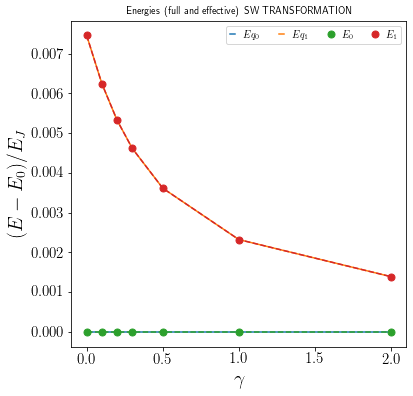

In [11]:
##Energies.
fig, ax1=plt.subplots(figsize=(6, 6))
ax1.plot(γ, Ep[:,:2] - Ep[:, 2*[0]], "-", γ, Ef[:,:2]-Ef[:,[0]*2] ,"--o",markersize=7, label='Inline label')
ax1.legend(('$Eq_0$','$Eq_1$','$E_0$','$E_1$','$E_2$','$E_3$'), ncol= 4, handlelength=0.5, )
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$(E-E_0)/E_J$') 
ax1.set_title('Energies (full and effective) SW TRANSFORMATION')

# First order predictions

The first order coupling in terms of the gap (see eq. 5 paper Ultrastong ...) is:
$$\frac{g^{(1)}_{qr}}{\Delta} = \frac{\overline{c}_q}{\overline{c}_g}\frac{\varphi^\star}{2}\sqrt{\frac{1}{2\pi G_0\mathcal{Z}}} $$
Taking into account the capacitance of a 3 Josephson junctions qubits and $c_g=\gamma C$, where $C$ is the capacitance of the big junction of the qubit:
$$\frac{g^{(1)}_{qr}}{\Delta} = \varphi_\star\frac{\overline{c}_q}{\overline{c}_g}\left(\frac{E_J^r}{32 E_C^r} \right)^{1/4}$$
the ratio of capacitances involved in previous formula is:
$$\frac{\overline{c}_q}{\overline{c}_g}= \frac{\gamma}{1+\gamma}
$$
where $r=E_C/E_C^r$ is the ratio between the big junction charging energy of the 3JJ qubit and the one of the single junction playing the role of LC resonator.

We notice the impedance has to contain the renormalized resonator capacitance, but to replace it by the single-qubit capacitance affects little to the results as it raised to a power 0.25.

# IMPORTANT
We need to introduce a factor 2 coming from the fact that we are computing coupling $H =\dots + g_n q_r *n_q$, where $n_q$ is the number of Cooper pairs in the qubit island. But from the theory we always work with the number of Cooper pairs, $H = \dots +g_t q_r q_q,$ where $q_q = 2n_q$. That implies $g_n = 2g_t$

In [12]:
def gqr_gap(gamma1, EJq, ECq, EJr, ECr, alpha, beta=0):
    if type(gamma1) == list:
        gamma = np.array(gamma1)
    else:
        gamma = gamma1
    phi_s = np.arccos(1/(2*alpha))
    ratio1 = ECq/ECr
    ECr_re = ECr * ratio1* (gamma+1+2*alpha+2*beta)/ ( ratio1*gamma+ (ratio1+gamma)*(1+2*alpha+2*beta)   )
    cr = gamma/(ratio1+gamma)
    g = phi_s * cr *(EJr/(ECr_re*32))**0.25
    gg = 2* g # the 2 factor is due to the fact that in numeric we work with cooper pair and in theory with charge
    return gg

The next cell computes the coupling, gap of qubit and frequency of resonator for a qubit resonator as a function of $\gamma$. As option pinta is set to true, it will output for each $\gamma$ the shape of the operator $H_b= tr[\sigma^y H_{eff}/2]$ where  on the bosonic degrees of freedom. This should be similar to a operator $i\ g(b^\dagger-b)$ (mind the phase may ve different than $i$ because of diagonalization includes arbitrary phases). 

In [30]:
alpha = 0.65
EJq = 1            # unit of energy
ECq = EJq/20       # Charging energy qubit large junction
EJr = EJq/40       # Josephson energy for the LC
r = 5
ECr = EJr/r
beta = 0
γ = [0.1*i for i in range(25)]

E_r, E_q, Ef , Ep, P = qubit_res(alpha, EJq, ECq, EJr, ECr, γ, beta = beta, nco = 10, fs = True, method = "SW", pinta = True)
#E_r2, E_q2, Ef2 , Ep2, P2 = qubit_res_old(alpha, EJq, ECq, EJr, ECr, γ, beta = beta, nco =20, fs = True, method = "SW", pinta = False)
delta_q_full = np.array([E_q[i][1]-E_q[i][0] for i in range(len(γ))])
delta_r_full = np.array([E_r[i][1]-E_r[i][0] for i in range(len(γ))])
gc_full = np.abs(P) 
print(delta_q_full, delta_r_full)

Hb/Hb[1,0]= 6.582619461548269e-16 *
[[-0.247 -0.084j  1.    -0.j     0.156 +0.536j  4.703-10.094j  4.912 -0.513j -0.933 -0.753j -0.436 -1.761j  0.046 +0.28j   0.839 -0.499j -0.167 -0.925j]
 [ 0.794 +0.608j  0.508 +0.172j -0.044 -0.913j  0.003 -0.474j -7.662 +8.674j  1.032 -0.002j -1.098 -0.026j -0.31  +0.163j  1.008 +0.533j  0.642 -0.1j  ]
 [ 0.449 -0.331j -0.59  +0.698j -0.344 -0.116j  0.017 +0.263j  0.008 +0.314j  3.742 -0.444j -2.437 -0.424j  0.123 -0.137j  0.264 -1.692j  0.511 +0.488j]
 [-2.398+10.874j -0.286 +0.378j  0.173 -0.198j  0.65  +0.22j  -0.787 +0.335j  0.159 -0.181j -6.685 +1.008j -4.467 -2.364j  0.576 -0.778j -1.929 -0.724j]
 [ 3.589 +3.392j -0.814-11.545j  0.198 -0.245j -0.421 -0.744j  0.997 +0.338j  0.177 -0.088j -0.533 +2.597j  3.105 -0.725j -2.153 -1.256j -0.289 -0.401j]
 [-1.199 +0.031j  0.819 +0.629j  2.702 +2.626j  0.016 +0.24j   0.087 +0.178j -0.458 -0.155j  0.661 -0.962j -0.002 +0.809j -0.269 -0.695j  1.658 -1.201j]
 [-1.416 +1.134j -0.888 -0.647j -2.193 -1.144j

Hb/Hb[1,0]= 3.0846593122527827e-06 *
[[  -0.   -0.j       1.   +0.j      -0.   +0.j       1.368+0.j       0.   -0.j      -0.958-0.j      -0.   +0.j      64.984+0.j       0.   -0.j     210.321-0.003j]
 [  -1.   +0.j      -0.   -0.j      -2.059-0.j       0.   +0.j      -0.654+0.j      -0.   -0.j       1.958-0.j       0.   +0.j    -113.137+0.019j    0.   +0.j   ]
 [   0.   +0.j       2.059-0.j      -0.   -0.j       2.077+0.j       0.   -0.j      -2.359-0.j      -0.   +0.j      92.394+0.j       0.   -0.j     299.046-0.005j]
 [  -1.368+0.j      -0.   +0.j      -2.077+0.j      -0.   -0.j      -0.971+0.j      -0.   -0.j      -0.86 -0.j       0.   -0.j     -30.325+0.j      -0.   +0.j   ]
 [  -0.   -0.j       0.654+0.j      -0.   -0.j       0.971+0.j      -0.   -0.j      -1.359-0.j      -0.   +0.j      -1.352+0.j       0.   -0.j       1.878-0.j   ]
 [   0.958-0.j       0.   -0.j       2.359-0.j       0.   -0.j       1.359-0.j      -0.   -0.j      -1.579-0.j      -0.   +0.j     -10.965+0.j      

Hb/Hb[1,0]= 1.305545340251962e-06 *
[[    0.      -0.j        1.      -0.j       -0.      +0.j        3.437   +0.j        0.002   -0.018j    17.733   +0.j       -0.132   +1.082j  -466.579   +0.j        2.874  -23.565j  1080.179   -0.j   ]
 [   -1.      -0.j        0.      -0.j      -25.343   -0.j       -0.005   +0.042j   -37.027   +0.j        0.296   -2.427j     9.971   -0.j        1.509  -12.37j   -279.615   +0.j     -423.269+3470.135j]
 [    0.      +0.j       25.343   +0.j       -0.      +0.j       50.144   +0.j        0.003   -0.026j    40.429   +0.j       -0.19    +1.558j  -685.352   +0.j        4.138  -33.927j  1828.635   -0.j   ]
 [   -3.437   -0.j        0.005   +0.042j   -50.144   -0.j       -0.      +0.001j   -52.938   -0.j        0.004   -0.03j     40.288   -0.j        0.019   -0.152j  -524.933   +0.j       -5.204  +42.659j]
 [   -0.002   -0.018j    37.027   +0.j       -0.003   -0.026j    52.938   +0.j        0.      -0.001j    20.354   +0.j       -0.004   +0.032j    -1.245 

Hb/Hb[1,0]= 2.778566863641252e-06 *
[[    0.      -0.j        1.      -0.j       -0.      +0.j        4.062   +0.j        0.01    -0.029j    22.657   +0.j       -0.367   +1.032j  -353.499   -0.j        4.683  -13.165j   502.06    -0.j   ]
 [   -1.      -0.j        0.      -0.001j   -27.968   -0.j       -0.017   +0.049j   -44.17    -0.j        0.365   -1.027j     4.299   +0.j       19.736  -55.48j   -123.268   -0.j     -693.102+1948.377j]
 [    0.      +0.j       27.968   +0.j       -0.      +0.001j    58.495   +0.j        0.015   -0.042j    52.113   +0.j       -0.535   +1.505j  -535.625   -0.j        6.828  -19.195j   968.764   -0.j   ]
 [   -4.062   -0.j        0.017   +0.049j   -58.495   -0.j       -0.      +0.002j   -66.643   -0.j        0.008   -0.022j    42.613   +0.j        0.421   -1.184j  -328.032   -0.j      -14.792  +41.573j]
 [   -0.01    -0.029j    44.17    +0.j       -0.015   -0.042j    66.643   +0.j        0.      -0.003j    26.144   +0.j       -0.019   +0.052j    -4.414 

Hb/Hb[1,0]= 1.0713334205891129e-05 *
[[    0.   +0.j     1.   -0.j    -0.   -0.j     4.146-0.j     0.   +0.j     8.692-0.j    -0.   -0.j   -39.65 +0.j     0.   +0.j  -564.312-0.j]
 [   -1.   +0.j    -0.   -0.j     1.879-0.j     0.   -0.j    -1.394+0.j    -0.   +0.j    27.561-0.j    -0.   +0.j   685.077+0.j     0.   -0.j]
 [    0.   -0.j    -1.879+0.j    -0.   -0.j   -16.653+0.j    -0.   +0.j   -32.414-0.j    -0.   -0.j    71.069+0.j     0.   +0.j -1116.308-0.j]
 [   -4.146+0.j    -0.   -0.j    16.653-0.j     0.   +0.j    31.874-0.j     0.   +0.j    80.996-0.j    -0.   -0.j   636.835+0.j    -0.   -0.j]
 [   -0.   +0.j     1.394+0.j     0.   +0.j   -31.874+0.j     0.   +0.j   -64.573+0.j     0.   -0.j   185.68 -0.j     0.   -0.j  -386.886-0.j]
 [   -8.692-0.j     0.   +0.j    32.414-0.j    -0.   +0.j    64.573-0.j    -0.   -0.j    25.268-0.j    -0.   +0.j  -193.231-0.j     0.   +0.j]
 [    0.   -0.j   -27.561-0.j     0.   -0.j   -80.996-0.j    -0.   -0.j   -25.268+0.j    -0.   -0.j   -58

First we plot spectrum of qubit renormalized:

[0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278 0.03162278] [0.099854   0.09168807 0.08472616 0.07871847 0.07348053 0.06887299 0.06478851 0.06114301 0.05786965 0.0549146  0.05223398 0.04979167 0.04755764 0.04550674 0.0436177  0.04187244 0.04025547 0.03875344 0.03735482 0.03604953 0.03482878 0.03368484 0.03261088 0.03160087 0.03064944]


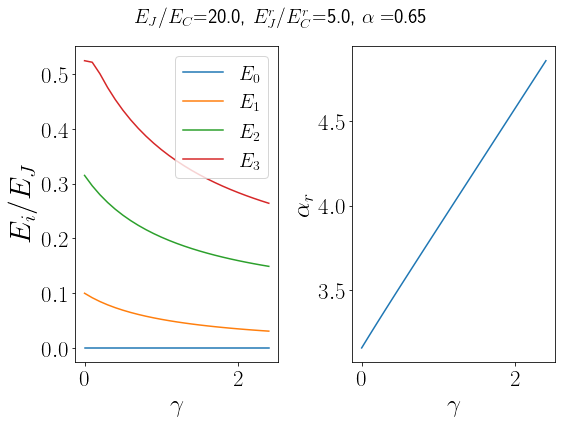

In [31]:
# # Plot the results for the qubit Hamiltonian showing the strength of the coupling.
print(delta_r_full, delta_q_full)
fig,(ax1,ax2) =plt.subplots(ncols=2, nrows=1,figsize=(8, 6))

#Plot the result for the energy of then system ad the comparision between the level splitting and the strength of the coupling.
# ax2.text(-5.2,0.17,'$\\textrm{(b)}$',fontsize=27)
fig.suptitle("$E_J/E_C$="+str(EJq/ECq)+", $E_J^r/E_C^r$="+str(EJr/ECr)+", $\\alpha=$"+str(alpha))
ax1.plot(γ, E_q-E_q[:,[0]*4], label='')
ax1.legend(('$E_0$', '$E_1$','$E_2$','$E_3$','$E_4$'),fontsize = 20)
ax1.set_xlabel('$\gamma$',  fontsize=25)
ax1.set_ylabel('$E/E_J$')
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$E_i/E_J$')

ax2.plot(γ, (E_q[:,2]-E_q[:,0])/(E_q[:,1]-E_q[:,0]))
ax2.set_ylabel("$\\alpha_r$", fontsize=25)
ax2.set_xlabel("$\\gamma$", fontsize=25)
# # plt.yscale('log')

plt.tight_layout()

Next, we give the coupling in units of gap and resonator frequency:

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004] [0.         0.00865033 0.01716832 0.02555326 0.03380516 0.04192463 0.04991272 0.05777082 0.06550056 0.07310381 0.08058254 0.08793886 0.09517495 0.10229303 0.10929536 0.1161842  0.12296185 0.12963055 0.13619255 0.14265008 0.14900533 0.15526046 0.16141759 0.16747881 0.17344617]


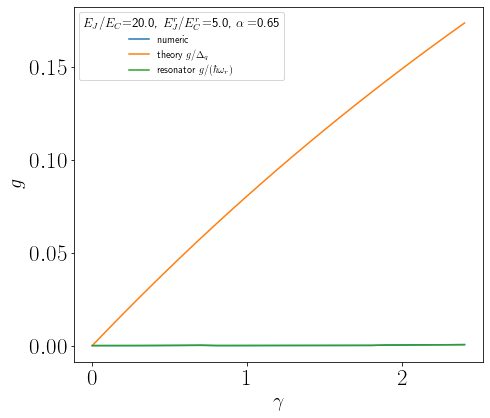

In [32]:
fig, (ax1)=plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
ax1.plot(γ,gc_full/delta_q_full, label = "numeric")
ax1.plot(γ,gqr_gap(γ, EJq, ECq, EJr, ECr, alpha, beta=beta), label = "theory $g/\Delta_q$")
ax1.plot(γ,gc_full/delta_r_full,  label = "resonator $g/(\\hbar \\omega_r)$")
ax1.legend(title = "$E_J/E_C$="+str(EJq/ECq)+", $E_J^r/E_C^r$="+str(EJr/ECr)+", $\\alpha=$"+str(alpha))
print(γ,gqr_gap(γ, EJq, ECq, EJr, ECr, alpha, beta=beta))
ax1.set_xlabel('$\gamma$', fontsize=20)
ax1.set_ylabel('$g$', fontsize=20) 
plt.tight_layout()

plt.savefig("coupling.pdf")

# Study of the cutoff:

KeyboardInterrupt: 

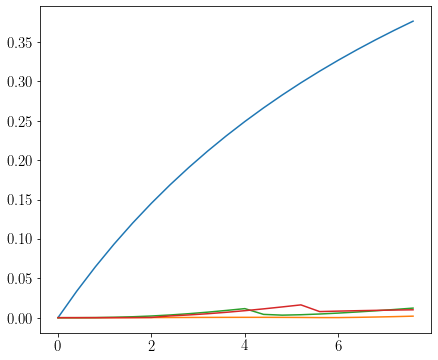

In [16]:
alpha = 0.65
EJq = 1           # unit of energy
ECq = EJq/20       # Charging energy qubit large junction
EJr = EJq/40      # Josephson energy for the single junction
r = 5
ECr = EJr/r
beta = 0
γ = [0.4*i for i in range(20)]

x = [4,8,12,16,20]

fig, (ax1)=plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
ax1.plot(γ,gqr_gap(γ, EJq, ECq, EJr, ECr, alpha, beta=beta), label = "theory $g/\Delta_q$")
for nco in x:
    E_r, E_q, Ef , Ep, P = qubit_res(alpha, EJq, ECq, EJr, ECr, γ, beta = beta, nco = nco, fs = True, method = "SW", pinta = False)
    delta_q_full = np.array([E_q[i][1]-E_q[i][0] for i in range(len(γ))])
    delta_r_full = np.array([E_r[i][1]-E_r[i][0] for i in range(len(γ))])
    gc_full = np.abs(P) 
    ax1.plot(γ,gc_full/delta_q_full, label = "numeric"+str(nco))
ax1.legend(title = "$E_J/E_C$="+str(EJq/ECq)+", $E_J^r/E_C^r$="+str(EJr/ECr)+", $\\alpha=$"+str(alpha))
print(γ,gqr_gap(γ, EJq, ECq, EJr, ECr, alpha, beta=beta))
ax1.set_xlabel('$\gamma$', fontsize=20)
ax1.set_ylabel('$g$', fontsize=20) 
plt.tight_layout()    
plt.savefig("cutoff.pdf")

# (v) Scale many data set

In [17]:
# This is to make all fonts latex in matplot lib
from matplotlib import rc
rc('text', usetex=True)
# Define the font size for each part of the plot:
SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=23)    # fontsize of the tick labels
plt.rc('ytick', labelsize=23)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)             # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We scale several cases as a function of the coupling at first order. First, read all data in directory which contains qubit-resonator coupolings:

In [18]:
import os
import re

pat = ["alpha(.*?)E", "EJq(.*?)rq", "rq(.*?)EJr","EJr(.*?)rr", "rr(.*?)nco", "nco(.*?)method", "method(.*?).dat" ]
fdata_p = []
para_p = []
# print(os.listdir("./"))
for f in os.listdir("./data/"):
    if f.startswith("alpha") and f.endswith(".dat"):
#         print(re.search("alpha(.*?)E", f).group(1))
        fdata_p.append(f)
        para_p.append([ re.search(a, f).group(1) for a in pat])


Order them in increasing order of g in units of the resonator energy:

In [19]:
coup = []
for j, f in enumerate(fdata_p):
    data = np.genfromtxt("./data/"+f)
    alpha = float(para_p[j][0])
#     print(j,alpha)
    EJq = float(para_p[j][1])
    ECq = EJq/float(para_p[j][2])
    EJr = float(para_p[j][3])
    ECr = EJr/float(para_p[j][4])    
#     if float(alpha) == 0.65:/
    γ = data[:,0]
    gc = data[:,1]
    delta_q = data[:,2]
    delta_r = data[:,3]
    coup.append( -gc[-1]/delta_r[-1])

indx = np.argsort(coup)
para = [para_p[indx[i]]  for i in range(len(para_p))]
fdata = [fdata_p[indx[i]]  for i in range(len(para_p))]


Print one case which to see that at resonance coupling can be similar to a 0.1:

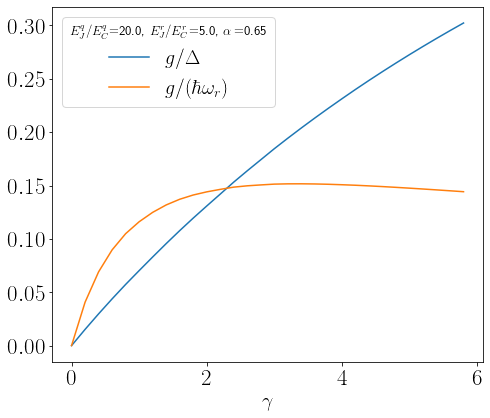

In [20]:
f_single = "alpha0.65EJq1rq20EJr0.025rr5nco30method_SW.dat"
para_single = [ re.search(a, f_single).group(1) for a in pat]

data = np.genfromtxt("./data/"+f_single)
alpha = float(para_single[0])
EJq = float(para_single[1])
ECq = EJq/float(para_single[2])
EJr = float(para_single[3])
ECr = EJr/float(para_single[4])   
nco = float(para_single[5])
γ = data[:,0]
gc = data[:,1]
delta_q = data[:,2]
delta_r = data[:,3]

fig, (ax1)=plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
ax1.plot(γ,gc/delta_q,label = "$g/\\Delta$")
ax1.plot(γ,gc/delta_r,label = "$g/(\\hbar \\omega_r)$")
ax1.legend(title = "$E_J^q/E_C^q$="+str(EJq/ECq)+", $E_J^r/E_C^r$="+str(EJr/ECr)+", $\\alpha=$"+str(alpha), fontsize = 20)
ax1.set_xlabel('$\gamma$', fontsize=20)
# ax1.set_ylabel('$$', fontsize=20) 
plt.tight_layout()

plt.savefig("coupling.pdf")

In [21]:
import matplotlib.pylab as pl
# color = []
n = len(para)
color = pl.cm.jet(np.linspace(0,1,n))

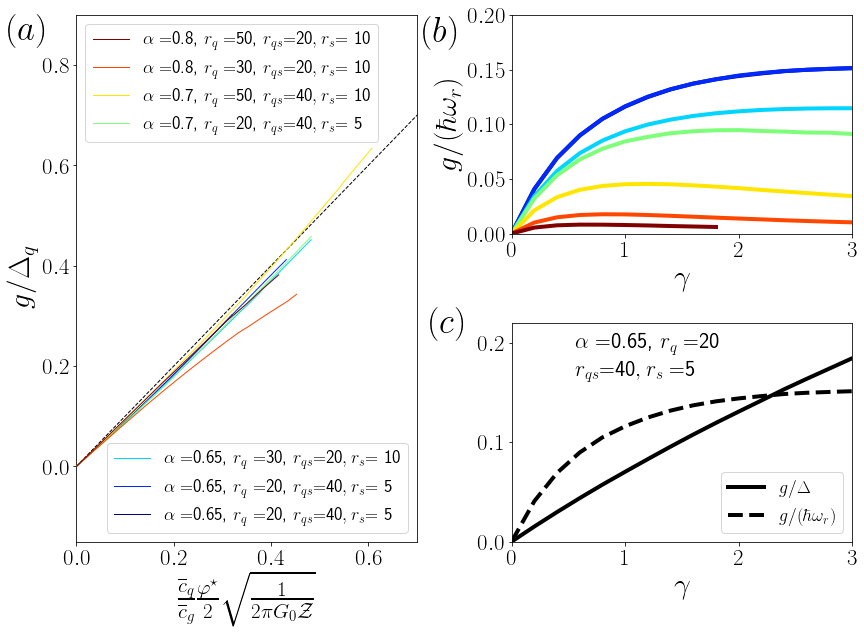

In [22]:

from pylab import *
# fig, (ax1, ax2)=plt.subplots(ncols=2, nrows=1, figsize=(11, 7))
plt.figure(figsize=(12.2, 9))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,4)
# ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3]

lin = [] 
lin_lab = []
legend1 = []
legend2 = []
label1 = []
label2 = []
nsplit = int(len(fdata) /2)
colors = []
for j, f in enumerate(fdata):
    data = np.genfromtxt("./data/"+f)
    alpha = float(para[j][0])
    EJq = float(para[j][1])
    ECq = EJq/float(para[j][2])
    EJr = float(para[j][3])
    ECr = EJr/float(para[j][4])   
    nco = float(para[j][5])
#     if nco == 30:
    γ = data[:,0]
    gc = data[:,1]
    delta_q = data[:,2]
    delta_r = data[:,3]
    x = gqr_gap(γ, EJq, ECq, EJr, ECr, alpha, beta=0)
    if j < nsplit:
        label1.append("$\\alpha=$"+str(para[j][0])+", $r_q=$"
             +para[j][2]+", $r_{qs}$="+str(int(1/EJr)) + "$, r_s$= "+para[j][4])
        p1,  = ax1.plot(x[:],gc[:]/delta_q[:], color =color[j], label = label1[j] ,zorder=j, linewidth=1)
        legend1.append(p1)
    else: 
        label2.append("$\\alpha=$"+str(para[j][0])+", $r_q=$"
             +para[j][2]+", $r_{qs}$="+str(int(1/EJr)) + "$, r_s$= "+para[j][4])        
        p2,  = ax1.plot(x[:],gc[:]/delta_q[:], color =color[j], label = label2[j-nsplit],zorder=j,linewidth=1)
        legend2.append(p2)
    ax2.plot(γ,gc/delta_r, label = "$\\alpha =$"+str(para[j][0])+", $r_q=$"
             +para[j][2]+", $E_J^r/E_J^q$="+str(round(EJr,2)) + "$, r_s$= "+para[j][4], color =color[j],  linewidth=4)
ax1.text(-0.2, 0.97, "$(a)$",verticalalignment='center', transform=ax1.transAxes, fontsize = 35)    
ax2.text(-0.26, 0.92, "$(b)$",verticalalignment='center', transform=ax2.transAxes, fontsize = 35)    
xx = np.linspace(0,2,100)
ax1.plot(xx,xx,"--", color = "black", linewidth=1)
ax1.set_xlabel('$\\frac{\overline{c}_q}{\\overline{c}_g}\\frac{\\varphi^\star}{2}\sqrt{\\frac{1}{2\pi G_0\mathcal{Z}}} $')
ax1.set_ylabel('$g/\\Delta_q$') 
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$g/(\\hbar\\omega_r)$') 
ax1.set_xlim([0, 0.7])
ax1.set_ylim([-0.15, 0.9])
ax2.set_ylim([0, 0.2])
ax2.set_xlim([0, 3])
# ###################################################################
# # Inset:
# ###################################################################
# f_s = "alpha0.65EJq1rq30EJr0.033333rr20nco30method_SW.dat"
js = fdata.index(f_single)
# para_single = [ re.search(a, f_single).group(1) for a in pat]

data = np.genfromtxt("./data/"+f_single)
alpha = float(para[js][0])
EJq = float(para[js][1])
ECq = EJq/float(para[js][2])
EJr = float(para[js][3])
ECr = EJr/float(para[js][4])   
nco = float(para[js][5])
#     if nco == 30:
γ = data[:,0]
gc = data[:,1]
delta_q = data[:,2]
delta_r = data[:,3]
# left, bottom, width, height = [0.16, 0.68, 0.25, 0.22]
# ax3 = fig.add_axes([left, bottom, width, height])
ax3.plot(γ,gc/delta_q,label = "$g/\\Delta$", color ="black", linewidth=4)
ax3.plot(γ,gc/delta_r, "--",label = "$g/(\\hbar \\omega_r)$", color = "black", linewidth=4)
ax3.text( -0.24, 1, "$(c)$",verticalalignment='center', transform=ax3.transAxes, fontsize = 35)
ax3.text(0.4, 0.84, "$\\newline \\alpha =$"+str(para_single[0])+", $r_q=$"
             +para_single[2]+"$\\newline \\newline  r_{qs}$="+str(int(1/EJr)) + "$, r_s=$"+para_single[4], 
              fontsize=22, horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
ax3.legend(fontsize = 18, loc =4)
# ax3.legend(fontsize = 18, loc =1, title = "$\\alpha =$"+str(para_single[0])+", $r_q=$"
#              +para_single[2]+", $E_J^r/E_J^q$="+str(round(EJr,2)) + "$, r_s=$"+para_single[4])
ax3.set_xlim([0, 3])
ax3.set_ylim([0, 0.22])
ax3.set_xlabel('$\gamma$')
# ###################################################################
###################################################################

plt.tight_layout()
l1 = ax1.legend(legend1[::-1], label1[::-1], loc=4, fontsize=18)
l2 = ax1.legend(legend2[::-1], label2[::-1], loc=2, fontsize=18)
# ax1.gca().add_artist(l1)
ax1.add_artist(l1)
# ax1.add_artist(legend1, label1, loc=2)
# ax1.add_artist(legend2, label2, loc=2)
# gca().add_artist(l1)
# ax1.legend(fontsize =12)

plt.savefig("Fig_qr.pdf", bbox_inches='tight')

# (vii) Qubit for ultra-strong coupling regime:

We consider qubit-qubit coupling at $\alpha=0.65$ and $r_{qs}=40$, $r_q=20$ and $r_r=5$. We will plot the spectrum of the renormalized qubit model. At $\gamma=2$ the renormalized qubit gap is the same as the renormalized resonator frequency, look to the previous plots. From this, we will find that the energy gap at zero detuning is aroun $\Delta\approx0.05
E_j$

In [17]:
alpha = 0.65
EJq = 1           # unit of energy
ECq = EJq/20      # Charging energy qubit large junction
EJr = EJq/40      # Josephson energy for the single junction
r = 5
ECr = EJr/r
beta = 0
γ = [0.1*i for i in range(30)]

E_r, E_q, Ef , Ep, P = qubit_res(alpha, EJq, ECq, EJr, ECr, γ, beta = beta, nco =6, fs = True, method = "SW")
delta_q_full = np.array([E_q[i][1]-E_q[i][0] for i in range(len(γ))])
delta_r_full = np.array([E_r[i][1]-E_r[i][0] for i in range(len(γ))])
gc_full = np.abs(P) 
# print(delta_q_full, delta_r_full)

We plot now the spectrum of the renormalized qubit Hamiltonian. That is, the full model is:

$$H= [q_q^2/(2\overline{C}) +f(\phi_q)]+ \hbar\overline{\omega}_rb^\dagger b+g\sigma_y(b+b^\dagger)$$

so now we will plot the spectrum of the tterm between parenthesis that corresponds to the renormalized qubit Hamiltonian. 

[0.099854   0.09168807 0.08472616 0.07871847 0.07348053 0.06887299 0.06478851 0.06114301 0.05786965 0.0549146  0.05223398 0.04979167 0.04755764 0.04550674 0.0436177  0.04187244 0.04025547 0.03875344 0.03735482 0.03604953 0.03482878 0.03368484 0.03261088 0.03160087 0.03064944 0.02975179 0.02890365 0.02810117 0.02734089 0.02661967]
[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004]


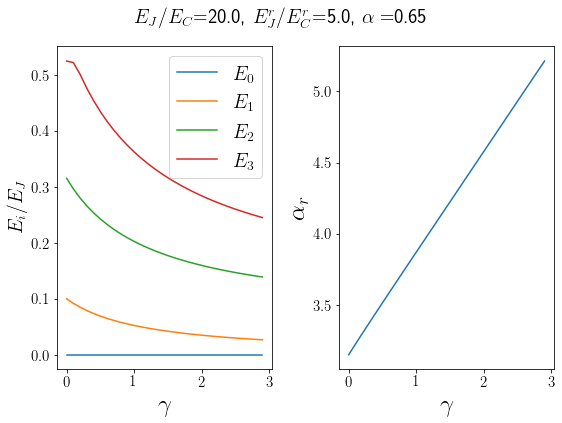

In [19]:
fig,(ax1,ax2) =plt.subplots(ncols=2, nrows=1,figsize=(8, 6))

fig.suptitle("$E_J/E_C$="+str(EJq/ECq)+", $E_J^r/E_C^r$="+str(EJr/ECr)+", $\\alpha=$"+str(alpha))
ax1.plot(γ, E_q-E_q[:,[0]*4], label='')
print(E_q[:,1]-E_q[:,0])
print(γ)
ax1.legend(('$E_0$', '$E_1$','$E_2$','$E_3$','$E_4$'),fontsize = 20)
ax1.set_xlabel('$\gamma$',  fontsize=25)
ax1.set_ylabel('$E_q/E_J$')
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$E_i/E_J$')

ax2.plot(γ, (E_q[:,2]-E_q[:,0])/(E_q[:,1]-E_q[:,0]))
ax2.set_ylabel("$\\alpha_r$", fontsize=25)
ax2.set_xlabel("$\\gamma$", fontsize=25)

plt.tight_layout()

To have a gap in the $\Delta=1Ghz$ regime we need to have a qubit junction $E_J=10Ghz.$ Then, the large qubit junction capacitance is $E_c = 0.5Ghz$ which translate into $C=55fF.$ Thus, we look for small junctions with critical current about $I_c=1.5\mu A$ and capacitances $C=55fF.$

This ratios are smaller than the ones for flux qubits, but are standard for other qubits as the fluxonium qubittjunctio.